In [40]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from autocorrect import Speller
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

### First things first, let's look a little bit at the data

In [4]:
test = pd.read_csv('test.txt', sep = ';',header = None )
test.head()
train = pd.read_csv('train.txt', sep = ';',header = None )
train.head()

,0,1
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
train[1].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: 1, dtype: int64

In [6]:
test[1].value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: 1, dtype: int64

The data is already separated into a test file and a training file so we don't need to do a train test split. As we can see the data isn't really made equal.

In [7]:
train.rename(columns = {1:'labels', 0:'sentences'}, inplace = True)
test.rename(columns = {1:'labels', 0:'sentences'}, inplace = True)

# Preprocessing the data

- Remove characters that are not letters
- apply .lower() to every word
- tokenization
- remove the stop words
- stemming 
- Correct the spelling

Removing non common characters. 

In [8]:
train.sentences = train.sentences.apply(lambda x: re.sub('[^A-Za-z]',' ', x))
test.sentences = test.sentences.apply(lambda x: re.sub('[^A-Za-z]',' ', x))

Apply .lower()

In [9]:
train.sentences = train.sentences.str.lower()
test.sentences = test.sentences.str.lower()

Tokenization

In [10]:
train.sentences = train.sentences.apply(lambda x: word_tokenize(x))
test.sentences = test.sentences.apply(lambda x: word_tokenize(x))

Removing stop words, correct spelling and stemming

In [11]:
spell_correcter = Speller()
stemmer  = PorterStemmer()

def remover_correct_stemm(message_columns: pd.Series):
    list_of_emails = []
    for row in tqdm(message_columns):
        lst = []
        for word in row:
            #remove the words that are stopwords
            if word not in stopwords.words('english'):
                #corrects the spelling
                corrected_word = spell_correcter(word)
                #stems each word
                word_stemm = stemmer.stem(corrected_word)
                #makes a new sentence without the stop words, with the word stemmed and without spelling errors
                lst.append(word_stemm)
        #appends to the big list
        lst = ' '.join(lst)
        list_of_emails.append(lst)
    return list_of_emails

In [12]:
train.sentences =remover_correct_stemm(train.sentences)
test.sentences =remover_correct_stemm(test.sentences)

100%|██████████| 2000/2000 [24:12<00:00,  1.38it/s]  


In [13]:
train.sentences

0                                        didnt feel humili
1        go feel hopeless damn hope around someon care ...
2                     im grab minut post feel greedi wrong
3           ever feel nostalg fireplac know still properti
4                                             feel grouchi
                               ...                        
15995        brief time beanbag said anna feel like beaten
15996     turn feel pathet still wait tabl dub teach degre
15997                              feel strong good overal
15998                       feel like rude comment im glad
15999                         know lot feel stupid portray
Name: sentences, Length: 16000, dtype: object

In [14]:
from sklearn.naive_bayes import MultinomialNB
counter = CountVectorizer()
x_train = counter.fit_transform(train.sentences).toarray()
x_test = counter.transform(test.sentences).toarray()
model = MultinomialNB()
model.fit(x_train, train.labels)

MultinomialNB()

In [15]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(test['labels'], model.predict(x_test)))
print('Accuracy:\n', accuracy_score(test['labels'], model.predict(x_test)))

              precision    recall  f1-score   support

       anger       0.84      0.66      0.74       275
        fear       0.79      0.59      0.68       224
         joy       0.76      0.93      0.84       695
        love       0.74      0.33      0.45       159
     sadness       0.75      0.89      0.82       581
    surprise       0.80      0.06      0.11        66

    accuracy                           0.77      2000
   macro avg       0.78      0.58      0.61      2000
weighted avg       0.77      0.77      0.75      2000

Accuracy:
 0.768


An accuracy of 76.8% isn't bad but it is also not very good. Instead of trying to connect the sentences with the 6 emotions, let's just try to predict if the sentence has a positive feeling attached to it or a negative.

In [16]:
train['positive'] = train.labels.map({'anger':0, 'fear':0, 'joy':1, 'love':1, 'sadness':0, 'surprise':1})
test['positive'] = test.labels.map({'anger':0, 'fear':0, 'joy':1, 'love':1, 'sadness':0, 'surprise':1})

In [19]:
positive_model = MultinomialNB()
positive_model.fit(x_train, train.positive)
print(classification_report(test.positive, positive_model.predict(x_test)))
print('Accuracy:\n', accuracy_score(test.positive, positive_model.predict(x_test)))


              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1080
           1       0.91      0.89      0.90       920

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000

Accuracy:
 0.9095


Since now we turned our problem into a binary problem, we can also try to use the Logistic regression model and see if it's better.

In [21]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train, train.positive)
print(classification_report(test.positive, model.predict(x_test)))
print('Accuracy:\n', accuracy_score(test.positive, model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1080
           1       0.94      0.94      0.94       920

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000

Accuracy:
 0.9425


An accuracy of 94.25% is pretty good! Let's see what words appear the most in each case.

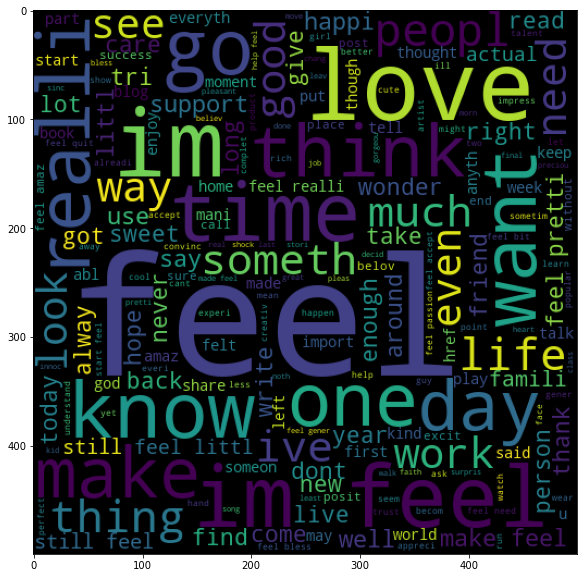

In [33]:
positive_words = ' '.join(list(train[train.positive == 1]['sentences']))
#This will allow us to visualize the most common words that appear in a positive sentence
positive_wc = WordCloud(width=500, height = 500).generate(positive_words)
plt.figure(figsize = (10,10))
plt.imshow(positive_wc)
plt.show()

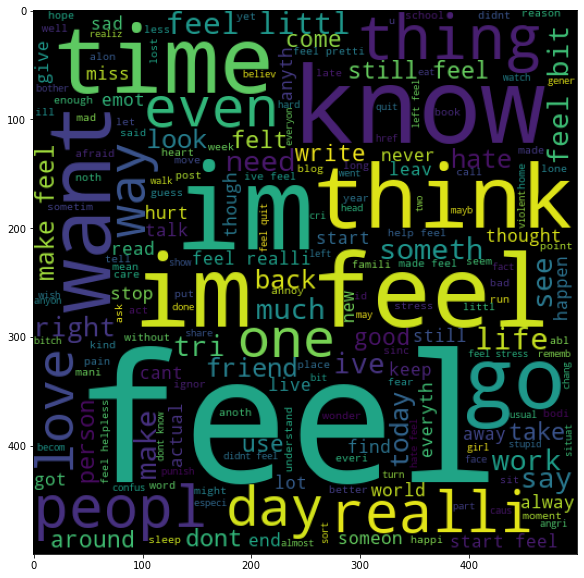

In [34]:
negative_words = ' '.join(list(train[train.positive == 0]['sentences']))
#This will allow us to visualize the most common words that appear in a negative sentence.
negative_words = WordCloud(width=500, height = 500).generate(negative_words)
plt.figure(figsize = (10,10))
plt.imshow(negative_words)
plt.show()

In [55]:
#most common words in negative sentences
negative_array = np.array((' '.join(train[train.positive == 0]['sentences'])).split(' '))
negative_series = pd.Series(negative_array).value_counts()
print(negative_series.head(10))

feel      9287
like      1537
im        1347
get        568
know       556
time       521
realli     501
want       493
go         484
make       459
dtype: int64


In [56]:
#most common words in positive sentences
positive_array = np.array((' '.join(train[train.positive == 1]['sentences'])).split(' '))
positive_series = pd.Series(positive_array).value_counts()
print(positive_series.head(10))

feel      7688
like      1481
im        1083
love       556
make       479
time       461
realli     444
get        416
go         401
know       385
dtype: int64


In [60]:
percentage = negative_series/positive_series
percentage.sort_values(ascending = False).head(5)

asham        75.0
punish       65.0
discourag    64.0
shaken       64.0
hopeless     64.0
dtype: float64

In [61]:
percentage = positive_series/negative_series
percentage.sort_values(ascending = False).head(5)

sympathet    59.0
curiou       57.0
nostalg      50.0
energet      50.0
contest      47.0
dtype: float64

## Conclusions
After text preprocessing and using a Multinomial Naive Bayes classifier, we were only able to correctly determine the sentiment 76.8% of the time. Considering that if we did it randomly we would get a 16.67% chance of getting the sentiment right, it doesn't seem so bad. However it is still not a very satisfactory result.

If we then aggregate the sentiments into a positive sentiment or a negative we can reach a way better result. Changing the approach to this, using a Logistic regression, we were able to get an accuracy of 94.25%.

It seems that the most common words in the positive sentences, like *feel*, *think* and *im* are present both in positive and negative sentences, which means that eliminating these words might be beneficial to the machine learning model. In the case of negative sentences, the 'words' *asham*, *punish*, *discourag* appear more than 64 times more often than in positive sentences. On the other end, *sympathet*, *curiou* and *nostalg* appear more than 50 times more often in positive sentences than in negative.